In [1]:
import asteroid
asteroid.__version__

'0.3.3'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
from pathlib import Path
import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
p = Path(r'Notebooks/MiniLibriMix').glob('**/*')
FILES = [x for x in p if x.is_file()]

In [4]:
class DataHelper(object):
    def __init__(self, files=FILES):
        self.files = files
        
    def __len__(self):
        return len(self.files)
        
    def get_file_types(self):
        strings = [str(f) for f in self.files]
        types = set(re.split('\.',s)[-1] for s in strings)
        return types
    
    def train_test_split(self):
        strings = [str(f) for f in self.files]
        train = [s for s in strings if re.search('/train/', s)]
        test = [s for s in strings if re.search('/val/', s)]
        return train, test
    
    def load_csv_tables(self):
        train, test = self.train_test_split()
        
        train_csvs = [t for t in train if re.search('.csv', t)]
        test_csvs = [t for t in test if re.search('.csv', t)]
        
        train_dfs = [pd.read_csv(t).rename(columns={'Unnamed: 0': 'index'}) for t in train_csvs]
        train_names = [re.split('/', re.split('\.', t)[-2])[-1] for t in train_csvs]
        
        test_dfs = [pd.read_csv(t).rename(columns={'Unnamed: 0': 'index'}) for t in test_csvs]
        test_names = [re.split('/', re.split('\.', t)[-2])[-1] for t in train_csvs]
        
        train_dict = dict(zip(train_names, train_dfs))
        test_dict = dict(zip(test_names, test_dfs))
        return train_dict, test_dict

In [5]:
datahelper = DataHelper()
len(datahelper)
datahelper.get_file_types()
train, test = datahelper.train_test_split()
len(train), len(test)
train_dfs, test_dfs = datahelper.load_csv_tables()

In [6]:
train_df = train_dfs['mixture_train_mix_clean']

In [7]:
example_1 = train_df.iloc[0]
example_1

index                                                           70
mixture_ID                         5400-34479-0005_4973-24515-0007
mixture_path     MiniLibriMix/train/mix_clean/5400-34479-0005_4...
source_1_path    MiniLibriMix/train/s1/5400-34479-0005_4973-245...
source_2_path    MiniLibriMix/train/s2/5400-34479-0005_4973-245...
length                                                      121920
Name: 0, dtype: object

In [8]:
mixture_path = example_1['mixture_path']
src_1_path = example_1['source_1_path']
src_2_path = example_1['source_2_path']

In [9]:
mixture, sr = librosa.load('Notebooks/'+mixture_path, sr=None)
src_1, _ = librosa.load('Notebooks/'+src_1_path, sr=None)
src_2, _ = librosa.load('Notebooks/'+src_2_path, sr=None)

In [10]:
def generate_spectrogram(signal, sr=8000, low_lim=0, high_lim=8000//2):
    S = librosa.stft(signal)
    return S

In [11]:
S_train = np.expand_dims(np.expand_dims(generate_spectrogram(mixture)[:1024, :128], axis=0),axis=0)
S_train.shape

(1, 1, 1024, 128)

In [12]:
S_test1 = np.expand_dims(generate_spectrogram(src_1)[:1024, :128], axis=0)
S_test2 = np.expand_dims(generate_spectrogram(src_2)[:1024, :128], axis=0)
S_test = np.expand_dims(np.concatenate([S_test1, S_test2], axis=0), axis=0)
S_test.shape

(1, 2, 1024, 128)

In [13]:
from IPython.display import Audio
Audio(librosa.core.istft(np.squeeze(S_train[0,0,:,:])), rate=8000)

In [14]:
Audio(librosa.core.istft(np.squeeze(S_test[0,0,:,:])), rate=8000)

In [15]:
Audio(librosa.core.istft(np.squeeze(S_test[0,1,:,:])), rate=8000)

In [16]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNET(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, 2, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out
    
unet = UNET()

In [17]:
from asteroid.losses import PITLossWrapper
from asteroid.losses import pairwise_mse, singlesrc_mse, multisrc_mse

In [18]:
unet = UNET().to('cuda')
S_X = torch.Tensor(S_train).to('cuda')
S_Y = torch.Tensor(S_test).to('cuda')
loss_func = asteroid.losses.PITLossWrapper(pairwise_mse, pit_from='pw_mtx')

import torch.optim as optim

criterion = loss_func
optimizer = optim.SGD(unet.parameters(), lr=0.01, momentum=0.9)

In [19]:
losses = []
for epoch in range(200):  # loop over the dataset multiple times

    X_inputs, Y_outputs = S_X, S_Y

    optimizer.zero_grad()

    outputs = unet(X_inputs)
    loss = criterion(outputs, Y_outputs)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    print(f'Epoch: {epoch} >>>>>>>>>>>>>> Loss: {loss.item()}')

Epoch: 0 >>>>>>>>>>>>>> Loss: 0.247608482837677
Epoch: 1 >>>>>>>>>>>>>> Loss: 0.24735736846923828
Epoch: 2 >>>>>>>>>>>>>> Loss: 0.24689209461212158
Epoch: 3 >>>>>>>>>>>>>> Loss: 0.2462550848722458
Epoch: 4 >>>>>>>>>>>>>> Loss: 0.24549078941345215
Epoch: 5 >>>>>>>>>>>>>> Loss: 0.24464327096939087
Epoch: 6 >>>>>>>>>>>>>> Loss: 0.24375389516353607
Epoch: 7 >>>>>>>>>>>>>> Loss: 0.24285846948623657
Epoch: 8 >>>>>>>>>>>>>> Loss: 0.24198636412620544
Epoch: 9 >>>>>>>>>>>>>> Loss: 0.24116000533103943
Epoch: 10 >>>>>>>>>>>>>> Loss: 0.2403959333896637
Epoch: 11 >>>>>>>>>>>>>> Loss: 0.23970559239387512
Epoch: 12 >>>>>>>>>>>>>> Loss: 0.23909485340118408
Epoch: 13 >>>>>>>>>>>>>> Loss: 0.23856504261493683
Epoch: 14 >>>>>>>>>>>>>> Loss: 0.23811383545398712
Epoch: 15 >>>>>>>>>>>>>> Loss: 0.23773503303527832
Epoch: 16 >>>>>>>>>>>>>> Loss: 0.23742090165615082
Epoch: 17 >>>>>>>>>>>>>> Loss: 0.23716136813163757
Epoch: 18 >>>>>>>>>>>>>> Loss: 0.23694580793380737
Epoch: 19 >>>>>>>>>>>>>> Loss: 0.236763462424

Epoch: 161 >>>>>>>>>>>>>> Loss: 0.1233062595129013
Epoch: 162 >>>>>>>>>>>>>> Loss: 0.12327446788549423
Epoch: 163 >>>>>>>>>>>>>> Loss: 0.12324383109807968
Epoch: 164 >>>>>>>>>>>>>> Loss: 0.12321409583091736
Epoch: 165 >>>>>>>>>>>>>> Loss: 0.12318514287471771
Epoch: 166 >>>>>>>>>>>>>> Loss: 0.12315680831670761
Epoch: 167 >>>>>>>>>>>>>> Loss: 0.12312895804643631
Epoch: 168 >>>>>>>>>>>>>> Loss: 0.12310150265693665
Epoch: 169 >>>>>>>>>>>>>> Loss: 0.12307438254356384
Epoch: 170 >>>>>>>>>>>>>> Loss: 0.12304762005805969
Epoch: 171 >>>>>>>>>>>>>> Loss: 0.12302112579345703
Epoch: 172 >>>>>>>>>>>>>> Loss: 0.12299482524394989
Epoch: 173 >>>>>>>>>>>>>> Loss: 0.12296880781650543
Epoch: 174 >>>>>>>>>>>>>> Loss: 0.12294302880764008
Epoch: 175 >>>>>>>>>>>>>> Loss: 0.12291751056909561
Epoch: 176 >>>>>>>>>>>>>> Loss: 0.12289224565029144
Epoch: 177 >>>>>>>>>>>>>> Loss: 0.12286721169948578
Epoch: 178 >>>>>>>>>>>>>> Loss: 0.1228424459695816
Epoch: 179 >>>>>>>>>>>>>> Loss: 0.12281797081232071
Epoch: 180 >>>

In [23]:
with torch.no_grad():
    out = unet(S_X)

In [24]:
out.size()

torch.Size([1, 2, 1024, 128])

In [26]:
out_np = out.cpu().numpy()
out1 = out_np[0,0,:,:]
out2 = out_np[0,1,:,:]

In [27]:
Audio(librosa.core.istft(out1), rate=8000)

In [28]:
Audio(librosa.core.istft(out2), rate=8000)

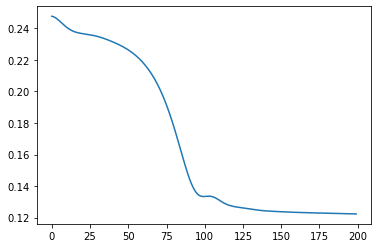

In [29]:
plt.plot(losses)